# The Rational Speech Act framework
Human language depends on the assumption of *cooperativity*, that speakers attempt to provide relevant information to the listener; listeners can use this assumption to reason *pragmatically* about the likely state of the world given the utterance chosen by the speaker.

The Rational Speech Act framework formalizes these ideas using probabiistic decision making and reasoning.

Note: This notebook must be run against Pyro 4392d54a220c328ee356600fb69f82166330d3d6 or later.

In [1]:
#first some imports
import torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

import collections
import argparse
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from search_inference import factor, HashingMarginal, memoize, Search

Before we can defined RSA, we specify a helper function that wraps up inference. `Marginal` takes an un-normalized stochastic function, constructs the distribution over execution traces by using `Search`, and constructs the marginal distribution on return values (via `HashingMarginal`).

In [2]:
def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

The RSA model captures recursive social reasoning -- a listener thinks about a speaker who thinks about a listener....

To start, the `literal_listener` simply imposes that the utterance is true. Mathematically:
$$P_\text{Lit}(s|u) \propto {\mathcal L}(u,s)P(s)$$

In code:

In [3]:
@Marginal
def literal_listener(utterance):
    state = state_prior()
    factor("literal_meaning", 0. if meaning(utterance, state) else -999999.)
    return state

Next the cooperative speaker chooses an utterance to convey a given state to the literal listener. Mathematically:

$$P_S(u|s) \propto [P_\text{Lit}(s|u) P(u)]^\alpha$$

In the code below, the `utterance_prior` captures the cost of producing an utterance, while the `pyro.sample` expression captures that the litteral listener guesses the right state (`obs=state` indicates that the sampled value is observed to be the correct `state`).

We use `poutine.scale` to raise the entire execution probability to the power of `alpha` -- this yields a softmax decision rule with optimality parameter `alpha`.

In [4]:
@Marginal
def speaker(state):
    alpha = 1.
    with poutine.scale(scale=torch.tensor(alpha)):
        utterance = utterance_prior()
        pyro.sample("listener", literal_listener(utterance), obs=state)
    return utterance

Finally, we can define the pragmatic_listener, who infers which state is likely, given that the speaker chose a given utterance. Mathematically:

$$P_L(s|u) \propto P_S(u|s) P(s)$$

In code:

In [5]:
@Marginal
def pragmatic_listener(utterance):
    state = state_prior()
    pyro.sample("speaker", speaker(state), obs=utterance)
    return state

Now let's set up a simple world by filling in the priors. We imagine there are 4 objects each either blue or red, and the possible utterances are "none are blue", "some are blue", "all are blue".

We take the prior probabilities for the number of blue objects and the utterance to be uniform.

In [6]:
total_number = 4

def state_prior():
    n = pyro.sample("state", dist.Categorical(probs=torch.ones(total_number+1) / total_number+1))
    return n

def utterance_prior():
    ix = pyro.sample("utt", dist.Categorical(probs=torch.ones(3) / 3))
    return ["none","some","all"][ix]

Finally, the meaning function (notated $\mathcal L$ above):

In [7]:
meanings = {
    "none": lambda N: N==0,
    "some": lambda N: N>0,
    "all": lambda N: N==total_number,
}

def meaning(utterance, state):
    return meanings[utterance](state)

Now let's see if it works: how does the pragmatic listener interpret the "some" utterance?

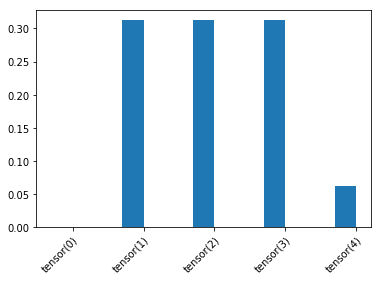

In [8]:
#silly plotting helper:
def plot_dist(d):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = list(map(str, support))

    ax = plt.subplot(111)
    width = 0.3
    bins = [x-width/2 for x in range(1, len(data) + 1)]
    ax.bar(bins,data,width=width)
    ax.set_xticks(list(range(1, len(data) + 1)))
    ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")
    
interp_dist = pragmatic_listener("some")
plot_dist(interp_dist)

Yay, we get a *scalar implicature*: "some" is interpretted as likely not including all 4. Try looking at the `literal_listener` too -- no implicature.